# Exploring raster data in Python 

Raster data consists of rows and columns of cells or pixels, with each cell representing a single value. This type of data is often thought of as images, although raster datasets can be stored in various formats such as **ASCII text files** or **Binary Large Objects (BLOBs)** within databases.

![Raster Data Representation](fig/raster_rep.png)

*Image Source: [ESRI - What is Raster Data](https://desktop.arcgis.com/en/arcmap/latest/manage-data/raster-and-images/what-is-raster-data.htm)*

Raster data represents the world as a grid of equally sized cells or pixels, where each cell has a value representing information, such as temperature, elevation, or land cover. There are two primary ways of working with raster data:

- Single-band raster: Each pixel has one value (e.g., elevation or temperature).
- Multiband raster: Each pixel has multiple values (e.g., Red, Green, and Blue bands in satellite imagery).

A key characterestic of of any raster data is its **Resolution**. Resolution refers to the ground distance that each cell represents. For example, if the resolution is two meterst, each cell corresponds to an area two meters by two meters. A raster dataset with higher resolution can show more detail, but it will also have larger file sizes.

Raster data can be stored in a variety of **formats**, some of the more common ones include:

- **TIFF (Tagged Image File Format)**: This is the most common geospatial raster format due to its flexibility. It allows for storage of multiple bands, metadata, and internal compression. However, TIFF files can sometimes be incompatible across software.
- **JPEG, GIF, BMP, PNG**: These formats are more suitable for images used in presentations or online applications. While common, they are not as robust for storing geospatial data due to lack of metadata support.
- **ASCII Grid**: This format is often used for storing elevation data as simple text files, with spatial information stored in a header.

## Raster data analysis with Python

In this lesson we will learn to perform raster GIS analysis using a number of Python libraries. You'll learn how to read, manipulate, analyze, and visualize raster data using `xarray`, `rioxarray`, and `xarray-spatial`. 

- [`xarray`](https://docs.xarray.dev/en/stable/): A powerful library for working with labeled, multi-dimensional arrays in Python. It is particularly useful for handling scientific data, including time series and spatial data.
- [`rioxarray`](https://corteva.github.io/rioxarray/stable/): An extension of `xarray` designed for geospatial raster data operations. It builds on top of `rasterio` to handle reading and writing raster formats like GeoTIFF, working with CRS (Coordinate Reference Systems), and performing GIS-specific tasks like reprojection. This combination allows for easy manipulation of spatial data in a highly efficient manner.
- [`xarray-spatial`](https://xarray-spatial.org/): A high-performance spatial analysis library that works with `xarray` to perform raster-based spatial analysis tasks such as terrain analysis, focal operations, and zonal statistics. It is designed for fast processing of large datasets.

These libraries are closely related to **`rasterio`**, which is the core library for handling raster data formats. [`rasterio`](https://rasterio.readthedocs.io/en/latest/) is built on the GDAL (Geospatial Data Abstraction Library) and provides efficient, low-level input and output operations for raster data, supporting various formats like GeoTIFF, PNG, and JPEG. It allows you to read and write raster files, access pixel values, manage CRS, and perform raster data manipulation.

`rioxarray` uses `rasterio` under the hood to handle the actual reading and writing of raster files. The flexibility of `xarray` combined with `rasterio`'s capabilities provides us with useful tools for analysis of raster data. 

In this part of our raster lesson, we will learn how to:

- Import and read raster data in Python
- Visualize raster data

## Loading raster data

For this lesson, we will work with two raster datasets (and briefly preview an additional one):

- Sentinetl 2 satelite image from Nuuksio national park in Finland. Data is obtained from [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu)
- Elevation model data retrieved from [National Land Survey of Finland](https://www.maanmittauslaitos.fi/en/maps-and-spatial-data/datasets-and-interfaces/product-descriptions/elevation-model-2-m).

### Loading Single-Band Raster Data

To load single-band raster data, we use the `rioxarray` library. `rioxarray` is built on top of `xarray` and `rasterio`. Under the hood, `rioxarray` utilizes `rasterio` to handle reading the raster file formats like GeoTIFF. This means that when we import a raster file using `rioxarray`, it uses `rasterio` to read the file and load it into an `xarray.DataArray` structure, making it easy to manipulate, visualize, and analyze the data.

The data we will use here elevation model data provided from [National Land Survey of Finland](https://www.maanmittauslaitos.fi/en/maps-and-spatial-data/datasets-and-interfaces/product-descriptions/elevation-model-2-m). Let's start with loading one of the four tiles that we will be working with later during this lesson (`L4133A.TIF`).

In [1]:
import rioxarray

raster_file = 'data/L4133A.TIF'

# Load a single-band raster
elevation_raster = rioxarray.open_rasterio(raster_file)

Let's have a look at the meatdata: 

In [2]:
print (elevation_raster)

<xarray.DataArray (band: 1, y: 3000, x: 3000)> Size: 36MB
[9000000 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 24kB 3.8e+05 3.8e+05 3.8e+05 ... 3.86e+05 3.86e+05
  * y            (y) float64 24kB 6.672e+06 6.672e+06 ... 6.666e+06 6.666e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0


We can see from the metadata that the raster file contains a single band with dimensions of 3000x3000 pixels, and the pixel values are stored as 32-bit floating point numbers. The coordinates are georeferenced, with `x` and `y` representing the spatial extent of the image, and there is a defined fill value of `-9999.0` for missing data.

Now let's check the CRS and then make a quick plot of our raster data to see what it looks like.

In [3]:
# Checking the CRS of our raster data
elevation_raster.rio.crs

CRS.from_epsg(3067)

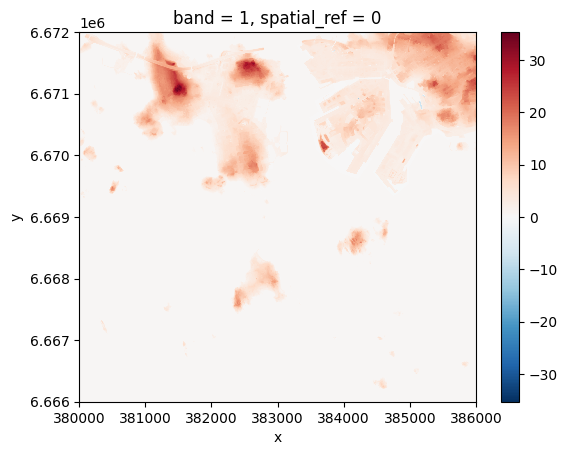

In [4]:
# Make a quick plot
elevation_raster.plot()

Now let's use numpy library and print some basic raster statistics:

In [5]:
# Print basic statistics
print(f"Min value: {elevation_raster.min().item()}")
print(f"Max value: {elevation_raster.max().item()}")
print(f"Mean value: {elevation_raster.mean().item()}")
print(f"Median value: {elevation_raster.median().item()}")
print(f"Standard deviation: {elevation_raster.std().item()}")

Min value: -19.166000366210938
Max value: 35.34000015258789
Mean value: 1.8909481763839722
Median value: 0.328000009059906
Standard deviation: 3.723005771636963


### Loading raster through WMS

Let's take a quick look at an example of how we can retrieve raster files or map images via **Web Map Service (WMS)**. WMS is a standard protocol developed by the **Open Geospatial Consortium (OGC)** that allows users to request and retrieve georeferenced map images over the internet, typically in common formats such as PNG, JPEG, and GeoTIFF. It's widely used in GIS applications, serving as a common method for organizations, like the City of Helsinki in our case, to share raster data.

In the example below, we fetch a base map of Helsinki from the [Helsingin kantakartta dataset](https://www.avoindata.fi/data/en_GB/dataset/helsingin-kantakartta/resource/070e6c10-1cf8-4e4e-8caa-2beddf6814f5?view_id=ce27e198-ff71-4829-b0c8-b9c88b2c4acd), which is provided by the Helsinki City Geographic Information Service through their WMS. This dataset includes detailed maps of the Helsinki area, containing information about land use, urban planning, and public infrastructure. We use [**OWSLib**](https://github.com/geopython/OWSLib) to retrieve the data and then read and visualize it using the `rioxarray` and `rasterio` libraries. The layer we work with, **"avoindata:Kantakartta"**, is in the WGS84 (EPSG:4326) coordinate system and covers part of the city.

Layer: avoindata:Kantakartta - Kantakartta
Layer: avoindata:Kantakartta_harmaa - Kantakartta_harmaa
Layer: avoindata:Kantakartta_varillinen - Kantakartta_varillinen
More layers available...


C:\Hyapp\Miniconda3\envs\cartogis\Lib\site-packages\rasterio\io.py:236: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  return DatasetReader(mempath, driver=driver, sharing=sharing, **kwargs)


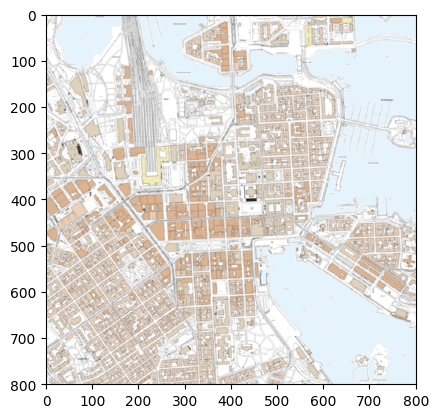

In [6]:
import requests
from owslib.wms import WebMapService
from io import BytesIO
import rasterio
from rasterio.plot import show

# WMS URL from Helsingin kantakartta dataset
wms_url = "https://kartta.hel.fi/ws/geoserver/avoindata/wms"

# Connect to the WMS service
wms = WebMapService(wms_url, version="1.3.0")

# List available layers (Only print the first 3 to avoide clutter)
for i, (layer_name, layer) in enumerate(wms.contents.items()):
    if i < 3:
        print(f"Layer: {layer_name} - {layer.title}")
    else:
        print("More layers available...")
        break

# Define the layer and bounding box (for Helsinki region)
layer_name = "avoindata:Kantakartta"
bbox = (24.93, 60.16, 24.97, 60.18)  # Example bounding box in EPSG:4326 (longitude, latitude)

# Define the GetMap request parameters
wms_request_url = wms.getmap(
    layers=[layer_name],
    srs='EPSG:4326',  # Coordinate system (WGS84)
    bbox=bbox,        # Bounding box for Helsinki area
    size=(800, 800),  # Image size in pixels
    format='image/png',  # Request PNG image format
    transparent=True
)

# Extract the actual URL from the ResponseWrapper
url = wms_request_url.geturl()  # This extracts the URL string

# Fetch the map from the WMS as a PNG image
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Load the image into rasterio
    with rasterio.open(BytesIO(response.content)) as src:
        # Plot the map image
        show(src)
else:
    print(f"Failed to retrieve WMS data. Status code: {response.status_code}")

### Loading a Multiband Raster File

In GIS and remote sensing, multiband raster files are commonly used to store imagery, such as satellite images, where each band represents a different wavelength of the electromagnetic spectrum (e.g., red, green, blue, near-infrared). In such files, each pixel has multiple values corresponding to the reflectance in different bands.

For this section, we will explore how to load a multiband raster file, examine the individual bands, and visualize the data. We'll be working with a multiband Sentinel-2 satellite image from Nuuksio National Park, located near Helsinki (`sentinel2_Nuuksio_small.tif`).

In [7]:
import rioxarray
import matplotlib.pyplot as plt
import numpy as np

Nuuksio_sentinel_path = "data/sentinel2_Nuuksio_small.tif"

# Load the multiband raster file
Nuuksio_sentinel = rioxarray.open_rasterio(Nuuksio_sentinel_path)

Let's plot our raster:

(array([3.440269e+06, 1.064389e+06, 1.615999e+06, 1.001865e+06,
        5.705210e+05, 1.751990e+05, 2.464800e+04, 2.109000e+03,
        1.010000e+02, 6.000000e+01]),
 array([0.        , 0.07777   , 0.15554   , 0.23331   , 0.31108001,
        0.38885   , 0.46662   , 0.54439002, 0.62216002, 0.69993001,
        0.77770001]),
 <BarContainer object of 10 artists>)

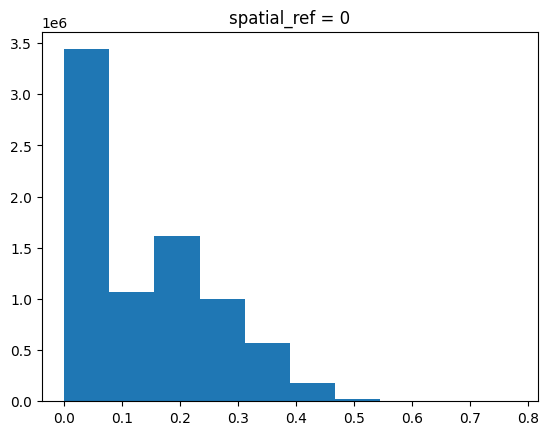

In [8]:
Nuuksio_sentinel.plot()

WHat just happened? The output is probabely not what you expected!

When you try to plot a multiband raster directly using the `plot()` function, `xarray` interprets the data as a multi-dimensional array and creates a summary, such as a bar chart, to represent the entire dataset. This happens because `xarray` doesn't know you're working with geospatial raster data and tries to plot all bands together, leading to an unexpected result like a bar chart.

To correctly visualize the raster data, you need to plot individual bands or create an RGB composite. But before getting there, let's have a look at the metadata: 

In [9]:
# Print metadata and band information
print(Nuuksio_sentinel)

<xarray.DataArray (band: 12, y: 723, x: 910)> Size: 32MB
[7895160 values with dtype=float32]
Coordinates:
  * band         (band) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 7kB 3.667e+05 3.667e+05 ... 3.757e+05 3.757e+05
  * y            (y) float64 6kB 6.696e+06 6.696e+06 ... 6.689e+06 6.689e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


From this metadata, we learn that the raster file contains 12 bands, each with dimensions of 723x910 pixels, and the pixel values are stored as 32-bit floating point numbers. The coordinates provide the geospatial reference with `x` and `y` representing the spatial extent, while each band corresponds to a different spectral band. Additionally, the file has attributes such as a scale factor of 1.0 and no offset applied.

However, this brief metadata does not tell us which spectral band does each raster band refer to. However, this is the kind of information that you should get from the data source. In our case, [Sentinel-2 User Guide](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi) is a good resource to find this information. 

For Sentinel-2 imagery, the bands are predefined and consistent across products. Here is a quick reference for the Sentinel-2 bands:

| **Band**   | **Description**                     | **Wavelength (nm)** |
|------------|-------------------------------------|---------------------|
| Band 1     | Coastal aerosol                     | 443 nm              |
| Band 2     | Blue                                | 490 nm              |
| Band 3     | Green                               | 560 nm              |
| Band 4     | Red                                 | 665 nm              |
| Band 5     | Vegetation Red Edge                 | 705 nm              |
| Band 6     | Vegetation Red Edge                 | 740 nm              |
| Band 7     | Vegetation Red Edge                 | 783 nm              |
| Band 8     | Near Infrared                       | 842 nm              |
| Band 8A    | Narrow Near Infrared                | 865 nm              |
| Band 9     | Water Vapor                         | 945 nm              |
| Band 10    | Short-Wave Infrared – Cirrus        | 1375 nm             |
| Band 11    | Short-Wave Infrared                 | 1610 nm             |
| Band 12    | Short-Wave Infrared                 | 2190 nm             |


These are the bands in our raster data, in order from 1 to 12. Depending on our data processing needs, we can use this reference to select the relevant bands for tasks such as true color composites (using Bands 4, 3, and 2) or vegetation analysis (using Bands 8 and 4 for NDVI).

Let's start by accessing the red band from our raster file. In (`rioxarray`), an individual band can be accessed using the `sel()` method, where you specify the band number. According to the reference above,  `band=4` retrieves the red band: 

In [10]:
# Access red band
red_band = Nuuksio_sentinel.sel(band=4)

Let's see what happen now if we try to plot this specific band of the raster file:

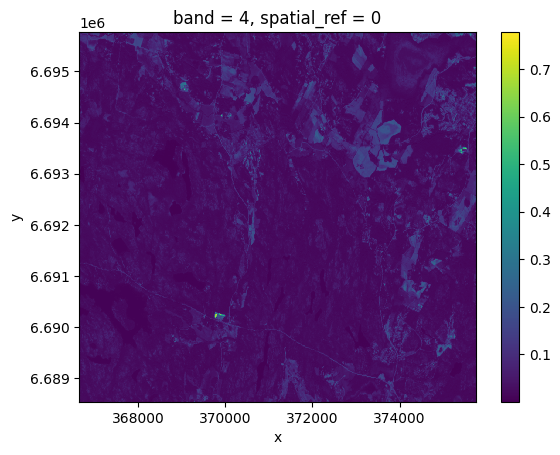

In [11]:
red_band.plot()

Now our raster file is visualized (the red band). We could also select the band and plot on the fly. let's try for the blue band (`band=2`).

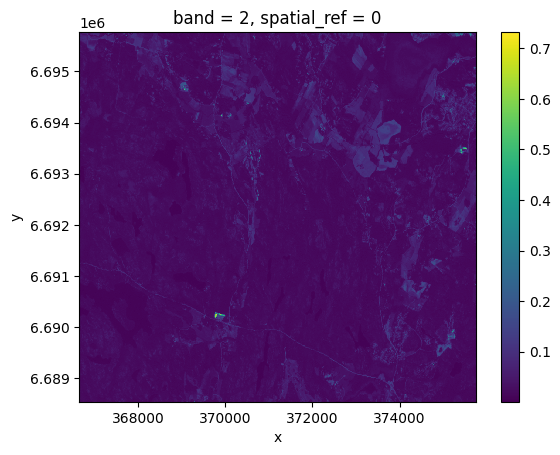

In [12]:
Nuuksio_sentinel.sel(band=2).plot()

### Creating an RGB Composite

In remote sensing and GIS, creating an RGB composite is a common method for visualizing multiband satellite imagery in natural or false colors. By combining the red, green, and blue bands of a satellite image, we can generate a true-color image that resembles what the human eye would see, or we can create false-color composites for enhanced analysis (e.g., vegetation health, water bodies, etc.).

For Sentinel-2 imagery, the red, green, and blue bands correspond to:
- **Red**: Band 4
- **Green**: Band 3
- **Blue**: Band 2

We accomplish this by loading the individual red, green, and blue bands, stacking them together into an RGB image, and normalizing the values to be suitable for display. The Numpy's `np.dstack()` function stacks arrays along a new depth axis (3rd dimension), which is useful for combining multiple 2D arrays (e.g., raster bands) into a 3D RGB image ([NumPy *dstack* documentation](https://numpy.org/doc/stable/reference/generated/numpy.dstack.html)). 

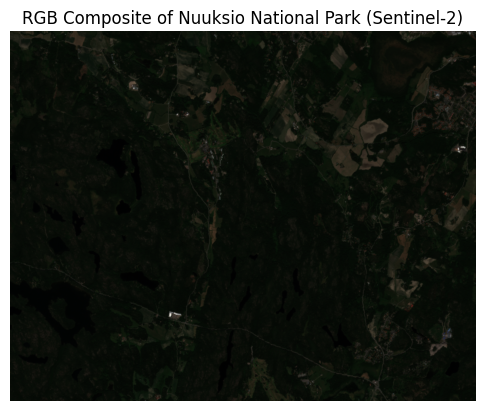

In [13]:
# Extract the red, green, and blue bands
red_band = Nuuksio_sentinel.sel(band=4)
green_band = Nuuksio_sentinel.sel(band=3)
blue_band = Nuuksio_sentinel.sel(band=2)

# Stack the bands together to create an RGB composite
rgb_image = np.dstack((red_band.values, green_band.values, blue_band.values))

# Normalize the image values between 0 and 1 by dividing by the max value
rgb_image = rgb_image / np.max(rgb_image)

# Plot the RGB composite image
plt.imshow(rgb_image)
plt.title("RGB Composite of Nuuksio National Park (Sentinel-2)")
plt.axis('off')  # Hide the axis for better visualization
plt.show()

Great! Now we can visualize the image in true color, just as it would appear to the human eye.